# Photonic Band Gap, lab report

Notebook con l'analisi dei dati raccolti sull'esperimento della banda fotonica.
I dati sono stati organizzati per data in diverse run (R0, R1, ...) e catalogati nella cartella labeldata.
Di seguito verranno importati tutti i dati che poi verranno nuovamente divisi in sottogruppi di interesse e 
analizzati. 

Da notare che non tutti i campi sono presenti in tutte le misure, questo perché il paradigma di misura è cambiato in opera durante la presa dati.

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from pprint import pprint
import scipy
from utils import *
import importlib

%matplotlib inline

# minimal plot style
plt.rcParams['figure.figsize'] = [10, 5]

# globals
prj_path = os.getcwd()
rel_path = 'labeldata'
full_path = os.path.join(prj_path, rel_path)
files = [f for f in os.listdir(full_path) if os.path.isfile(os.path.join(full_path, f))]
print(f'importing these files:')
pprint(files, compact=True)

df = pd.concat([pd.read_csv(os.path.join(rel_path, file)) for file in files])
print(f"list of measured samples: {df['sample'].unique()}")

df

importing these files:
['20-06-24_R1.txt', '20-06-24_R10.txt', '20-06-24_R11.txt', '20-06-24_R12.txt',
 '20-06-24_R13.txt', '20-06-24_R14.txt', '20-06-24_R15.txt', '20-06-24_R16.txt',
 '20-06-24_R17.txt', '20-06-24_R18.txt', '20-06-24_R19.txt', '20-06-24_R2.txt',
 '20-06-24_R3.txt', '20-06-24_R4.txt', '20-06-24_R5.txt', '20-06-24_R6.txt',
 '20-06-24_R7.txt', '20-06-24_R8.txt', '20-06-24_R9.txt', '30-05-24_R0.txt',
 '30-05-24_R1.txt', '30-05-24_R2.txt', '30-05-24_R4.txt', '30-05-24_R5.txt',
 '30-05-24_R6.txt', '30-05-24_R7.txt']
list of measured samples: ['PCR' 'SIL' 'BOX' 'AIR' 'CAL']


,id,frequency_GHz,peak_mV,sigma_peak_mV,noise_mV,sigma_noise_mV,sample,antenna
0,20-06-24_R1,0.250000,0.077777,1.418710e-02,0.030717,0.001266,PCR,LF
1,20-06-24_R1,0.333333,7.122130,9.501470e-16,0.179667,0.001633,PCR,LF
2,20-06-24_R1,0.416667,7.147800,0.000000e+00,0.171667,0.002733,PCR,LF
3,20-06-24_R1,0.500000,6.821190,0.000000e+00,0.197167,0.001329,PCR,LF
4,20-06-24_R1,0.583333,6.855540,1.580340e-01,0.170833,0.010534,PCR,LF
...,...,...,...,...,...,...,...,...
65,30-05-24_R7,5.666670,11.600000,NaN,0.223000,NaN,CAL,CAB
66,30-05-24_R7,5.750000,13.700000,NaN,0.257000,NaN,CAL,CAB
67,30-05-24_R7,5.833330,11.600000,NaN,0.223000,NaN,CAL,CAB
68,30-05-24_R7,5.916670,10.500000,NaN,0.211000,NaN,CAL,CAB


## Analisi della distorsione del segnale

Come prima cosa è opportuno valutare la presenza di artefatti dell'apparato di misura che andranno sottratti dal segnale. 
Sia il generatore che l'analizzatore danno delle risposte diverse a diverse frequenze, ad esempio il generatore produce un segnale più intenso a basse frequenze, e così via. Ci sono anche gli effetti prodotti dalla scatola con la schermatura, essa produce delle onde stazionarie e delle risonanze che si sommano all'effetto del cristallo fotonico.
In particolare l'analisi del rumore deve tenere conto di:

- distorsioni del generatore e del ricevitore in presa diretta (CAL)
- effetti dovuti alla configurazione reciproca in aria dell'antenna e ricevitore (AIR)
- onde stazionarie dovute alla presenza dell'apparato di schermamento (BOX)

Cominciamo quindi dall'analisi di queste due per capire i loro effetti

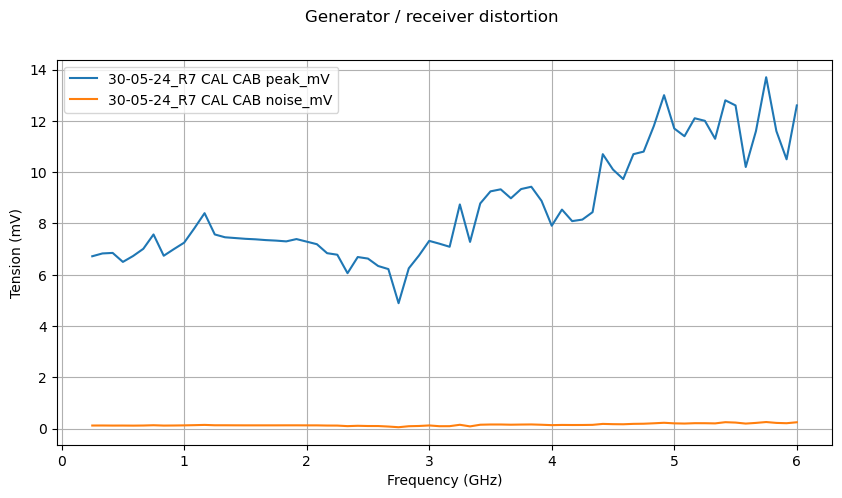

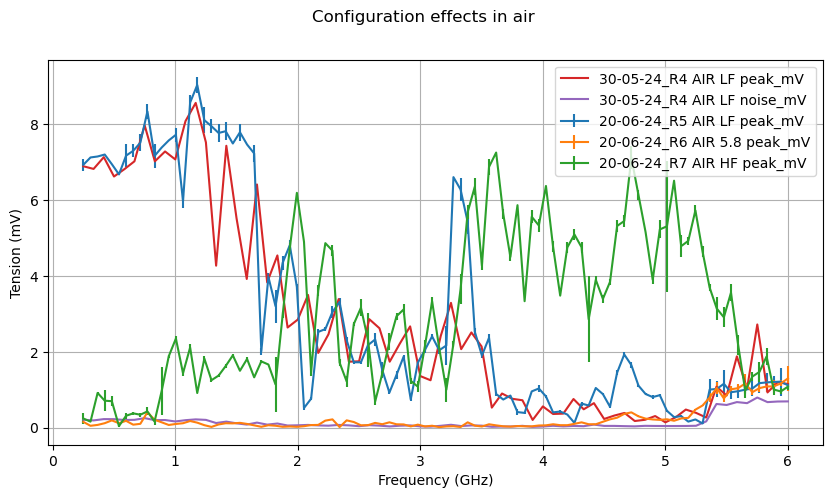

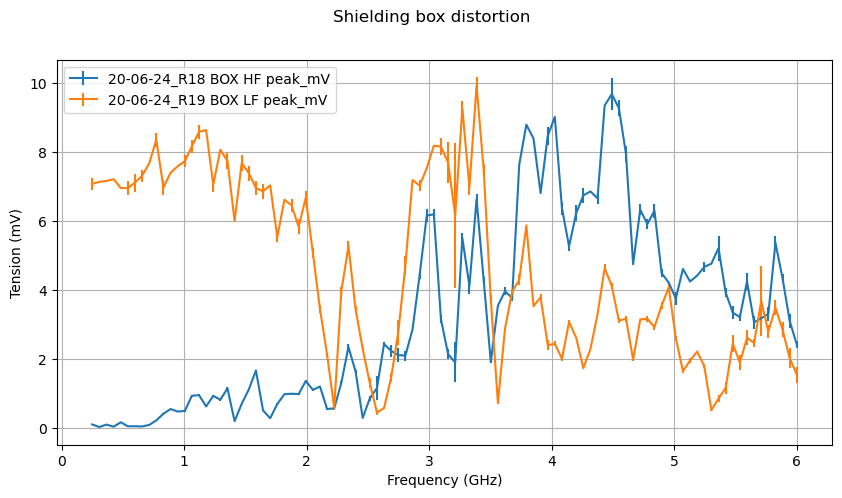

In [2]:
plotByID(df[df['sample'] == 'CAL'], 'Generator / receiver distortion')
plotByID(df[df['sample'] == 'AIR'], 'Configuration effects in air')
plotByID(df[df['sample'] == 'BOX'], 'Shielding box distortion')

Dal grafico "Generator \ Reciever distortion" emerge che il segnale non ha lo stesso gain su tutta la banda, andrà quindi rinormalizzato per eliminare l'amplificazione del segnale da parte dei trasmettitori in questo modo:

$$
 normalized\_signal = \frac{signal}{cal\_signal - cal\_noise}
$$

Lo scopo dell'esperimento non è misurare la potenza effettiva del segnale, ma capire l'effetto del cristallo fotonico nella propagazione di quest'ultimo. 
Possiamo quindi rimuovere il rumore in una prima parte dell'analisi e poi procedere al confronto con un particolare set di misure rinormalizzando i dati.
Il paradigma che vogliamo seguire è il seguente:

1. Rimozione del rumore dal segnale
    - Gain effects
    - Artefatti periodici (da dove derivano?)
    - Dipendenza delle misure dal tempo
1. Analisi dati normalizzando su un campione di confronto

Per eliminare effetti dovuti alle fluttuazioni del segnale sarebbe da interpolare il gain con una funzione continua. Per motivi di semplicità si è scelto di usare un polinomio di secondo grado come approssimante. 
A questo punto vogliamo anche valutare qual'è lo spettro della misura, corretto per il gain, in diverse configurazioni via via più complesse, confrontandole due a due in modo da ricostruire gli effetti che ha cambiare qualcosa:

1. spettro intensità in aria
1. spettro con scatola di contenimento vuota (sarà importante per i successivi confronti)
1. spettro con silicio a varie altezze 
1. spettro con cristallo fotonico

## Analisi del rumore e gain 
Come prima cosa facciamo il fit del segnale del gain:

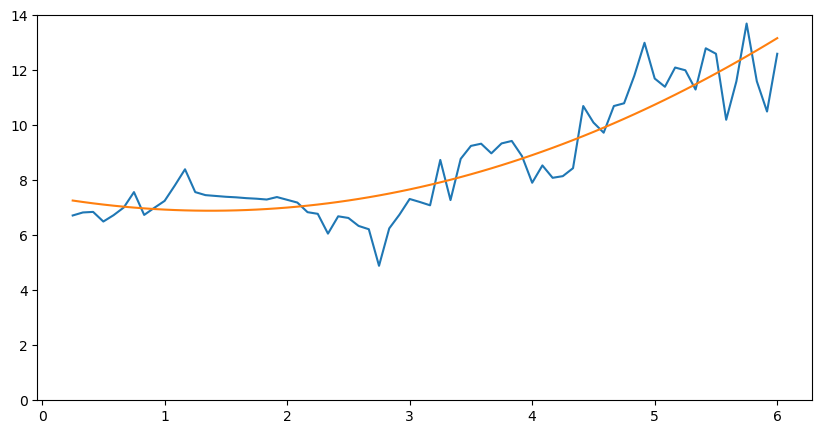

In [3]:
def getGain():
    '''
        Get the gain for each frequency by interpolating
        the measures as a polynomial
    '''
    subset = df[df['sample'] == 'CAL']
    x = subset['frequency_GHz'].values.tolist()
    y = subset['peak_mV'].values.tolist()
    coeff = np.polyfit(x,y,2)

    ax = plt.subplot()
    ax.plot(x,y)
    ax.plot(x, np.polyval(coeff, x))

    ax.set_ylim(0,14)
    return coeff

gain_coeff = getGain()

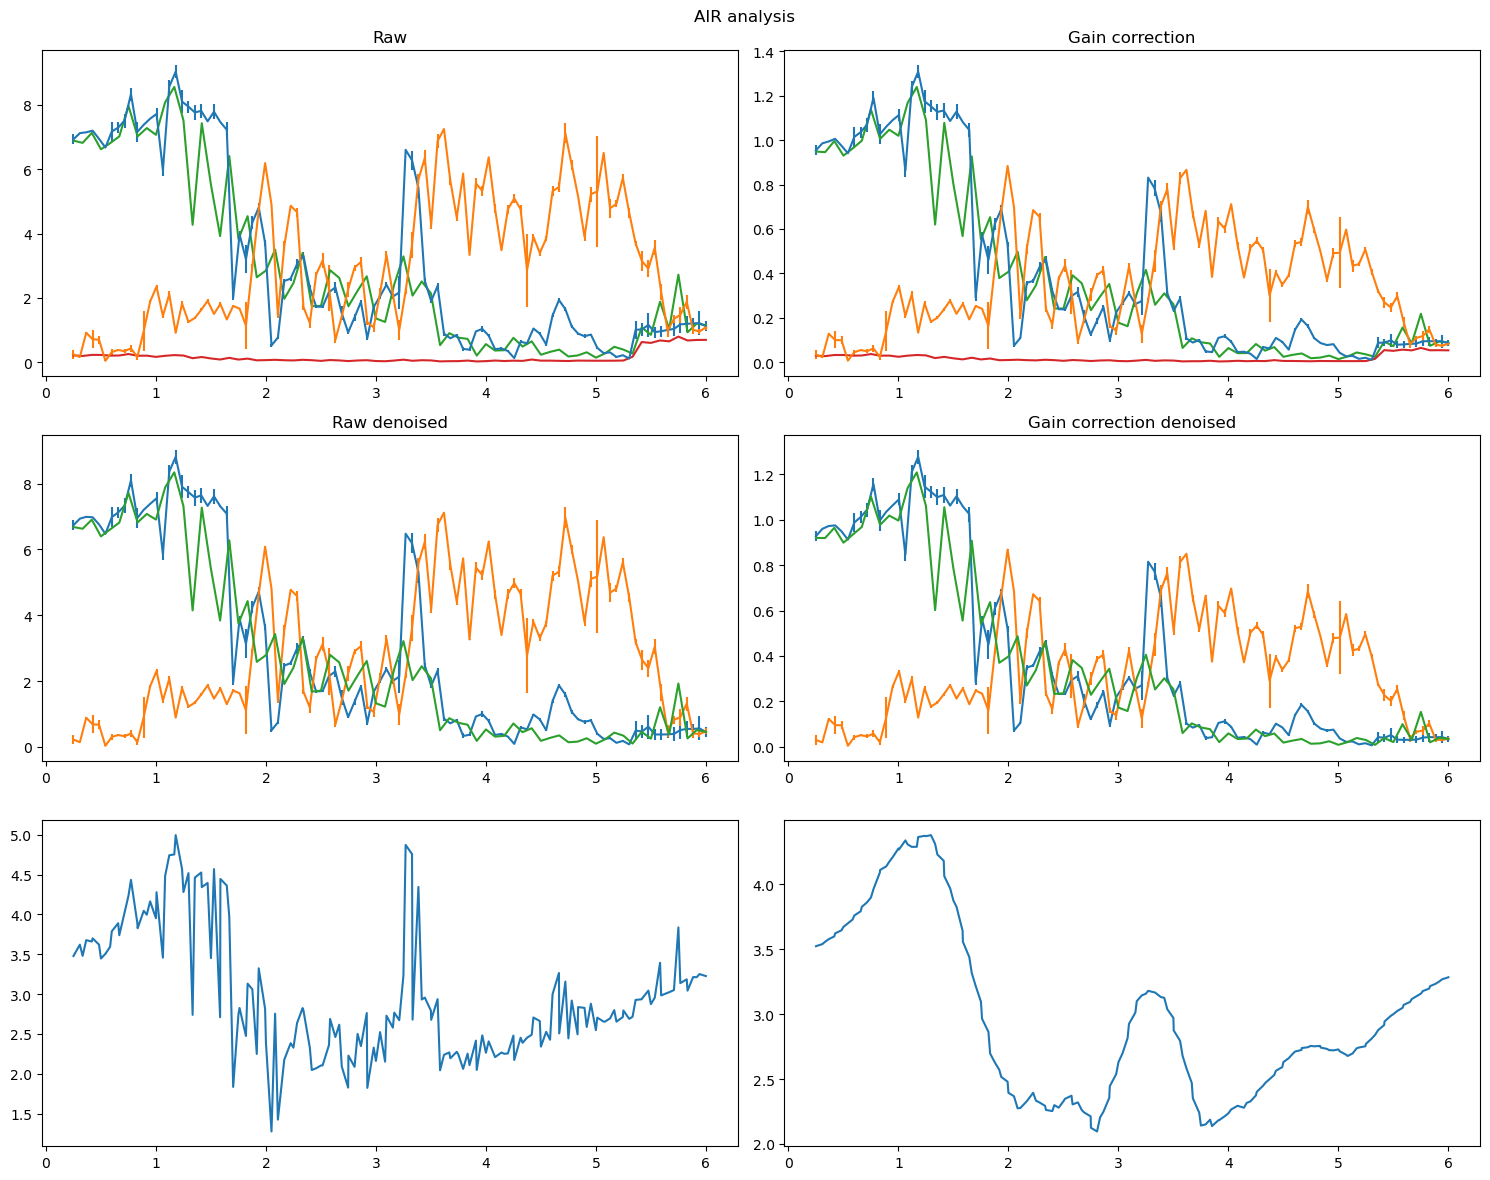

In [4]:
import scipy.fft
import scipy.signal


def testStuff():
    '''
        Try some stuff with AIR signals
    '''
    subset =  df.query(' sample == "AIR" and antenna != 5.8 ')

    fig, axs = plt.subplots(3,2, figsize = (15,12))

    # RAW
    subset.groupby(subset['id']).apply(plotThis, axs[0,0])
    axs[0,0].set_title('Raw')

    # GAIN CORRECTION
    correctGain(subset, gain_coeff).groupby('id').apply(plotThis, axs[0,1])
    axs[0,1].set_title('Gain correction')

    # RAW DENOISED
    denoised = subset.apply(denoise, axis=1)
    denoised.groupby('id').apply(plotThis, axs[1,0])
    axs[1,0].set_title('Raw denoised')

    # GAIN CORRECTION DENOISED
    correctGain(denoised, gain_coeff).groupby('id').apply(plotThis, axs[1,1])
    axs[1,1].set_title('Gain correction denoised')

    # MEAN RAW DENOISED
    m = denoised[denoised['antenna'] == 'LF']
    m = m[[k.freq, k.pek]].groupby(k.freq).apply(np.mean)

    axs[2,0].plot(m.index.values, m.values)
    
    #  denoised signal
    axs[2,1].plot(m.index.values, scipy.signal.savgol_filter(m.values, 30, 2))

    fig.suptitle('AIR analysis')
    fig.tight_layout()

testStuff()

# Analisi della dipendenza temporale del segnale
Adesso vogliamo concentrarci su quello che sembrerebbe essere un problema di riproducibilità dei dati: a tempi diversi si misurano diverse cose. Questo è ovviamente un problema, ma forse è possibile interpolare i dati per estrarre un segnale pulito.

I dati presi in funzione del tempo non sono inseriti all'interno dei *labeldata* ma sono stati lasciati nei *rawdata*. Importandoli e facendo un plot si analizza il segnale nel tempo:

Index(['Frequency (GHz)', 'Peak (mV)', 'Noise (mV)', 'Time (s)',
       'SigPeak (mV)', 'SigNoise (mV)'],
      dtype='object')


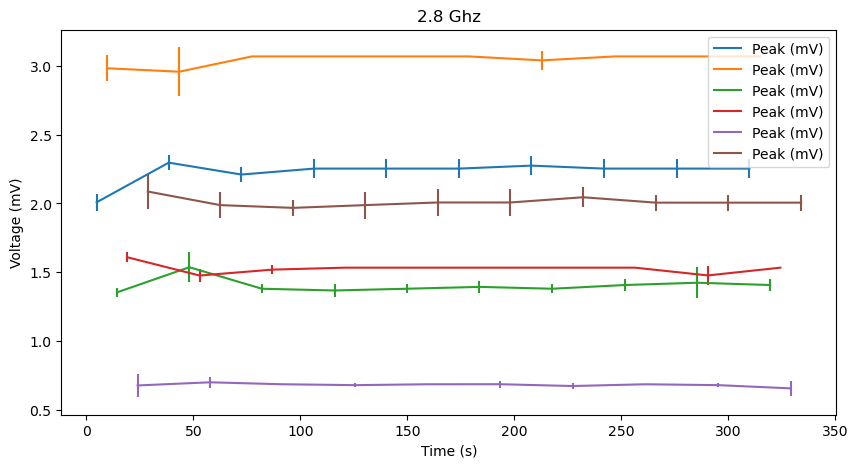

In [5]:
def TimeDependenceOfTheSignal():
    
    path = os.path.join(prj_path, 'rawdata', '20-06-24' ,'HF_LNA_PCR_R12.txt')
    data = pd.read_csv(path)
    
    print(data.columns.unique())
    
    fig, ax = plt.subplots()
    
    for name, group in data.groupby('Frequency (GHz)'):
        group.plot(x='Time (s)', y='Peak (mV)', yerr='SigPeak (mV)', 
                   title=' '.join([str(name), 'Ghz']), 
                   ylabel='Voltage (mV)', ax=ax)
    return

TimeDependenceOfTheSignal()

Da questa analisi preliminare il segnale sembrerebbe essere stabile... 
Abbiamo anche ripetuto una stessa misura due volte, vediamo se le due misure sono coerenti. R8 R9 R10 sono tutte la stessa misura, ma R9 ed R10 hanno 60 punti, mentre R8 ne ha di più. Confrontando R9 ed R10 è possibile vedere se la misura è riproducibile.

             id  frequency_GHz   peak_mV  sigma_peak_mV  noise_mV  \
55  20-06-24_R9        5.61017  0.768808       0.087299  0.490667   
56  20-06-24_R9        5.70763  0.863090       0.194798  0.514333   
57  20-06-24_R9        5.80508  0.917316       0.098674  0.562667   
58  20-06-24_R9        5.90254  0.917696       0.124338  0.593667   
59  20-06-24_R9        6.00000  0.987089       0.146268  0.611667   

    sigma_noise_mV sample antenna  
55        0.007763    PCR      HF  
56        0.006408    PCR      HF  
57        0.007005    PCR      HF  
58        0.006022    PCR      HF  
59        0.004676    PCR      HF  
['20-06-24_R10' '20-06-24_R9']


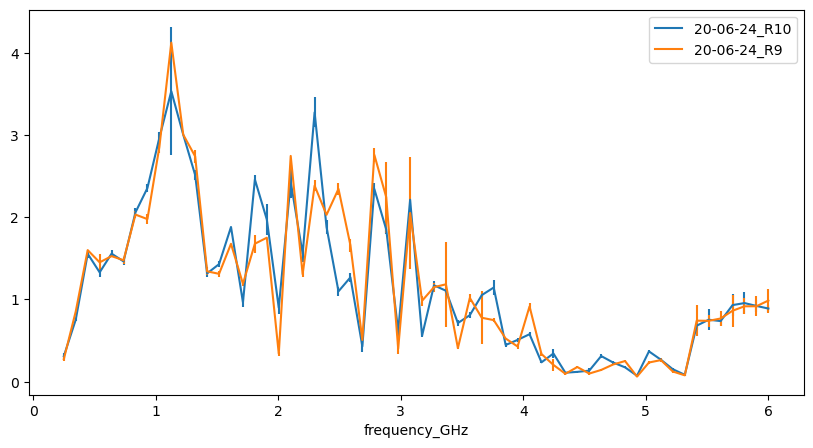

In [6]:
def ReproducibilityOfTheMeasures():
    data = df[df['id'].isin(['20-06-24_R9','20-06-24_R10'])]
    print(data.tail())
    print(data['id'].unique())
    
    fig, ax = plt.subplots()
    
    for name, group in data.groupby('id'):
        
        group.plot(x=k.freq, y=k.pek, yerr=k.sig_pek,
                   ax=ax, label=name)
    

    return
ReproducibilityOfTheMeasures()

Si vede dal grafico che i due segnali non sono compatibili in alcuni punti. Questo potrebbe essere dovuto al fatto che l'incertezza statistica sui punti è calcolata su periodi molto brevi (circa un secondo), mentre le variazioni del segnale sono per tempi lunghi. Verrebbe anche da dire che i risultati di questo grafico sono incompatibili con l'analisi del segnale nel tempo fatta nella sezione prima in quanto le oscillazioni tra due e tre gigahertz qui sono molto maggiori di quelle osservate in tre minuti. Serviranno altri modi per rimuovere il rumore dai dati. Potrebbe anche essere che quello che abbiamo osservato fosse rumore ambientale, non è da escludere.

## Ricostruzione del segnale sulle misure 8-9-10
Adesso mettiamo insieme queste tre misure per ricostruire il segnale al meglio possibile.

Il sendo di quello che verrà fatto adesso è fare un elaborazione del segnale usando la sua trasformata di Fourier, applicando due filtri:
- ampiezza: teniamo solo le frequenze che contribuiscono in maniera cospicua al segnale
- frequenza: togliamo le alte frequenze che potrebbero essere associate al rumore

La scelta di quanto filtro applicare è arbitraria e il rischio è rimuovere anche la parte di segnale che ci interessa... procediamo quindi per tentativi e vediamo se quello che otteniamo ha senso.

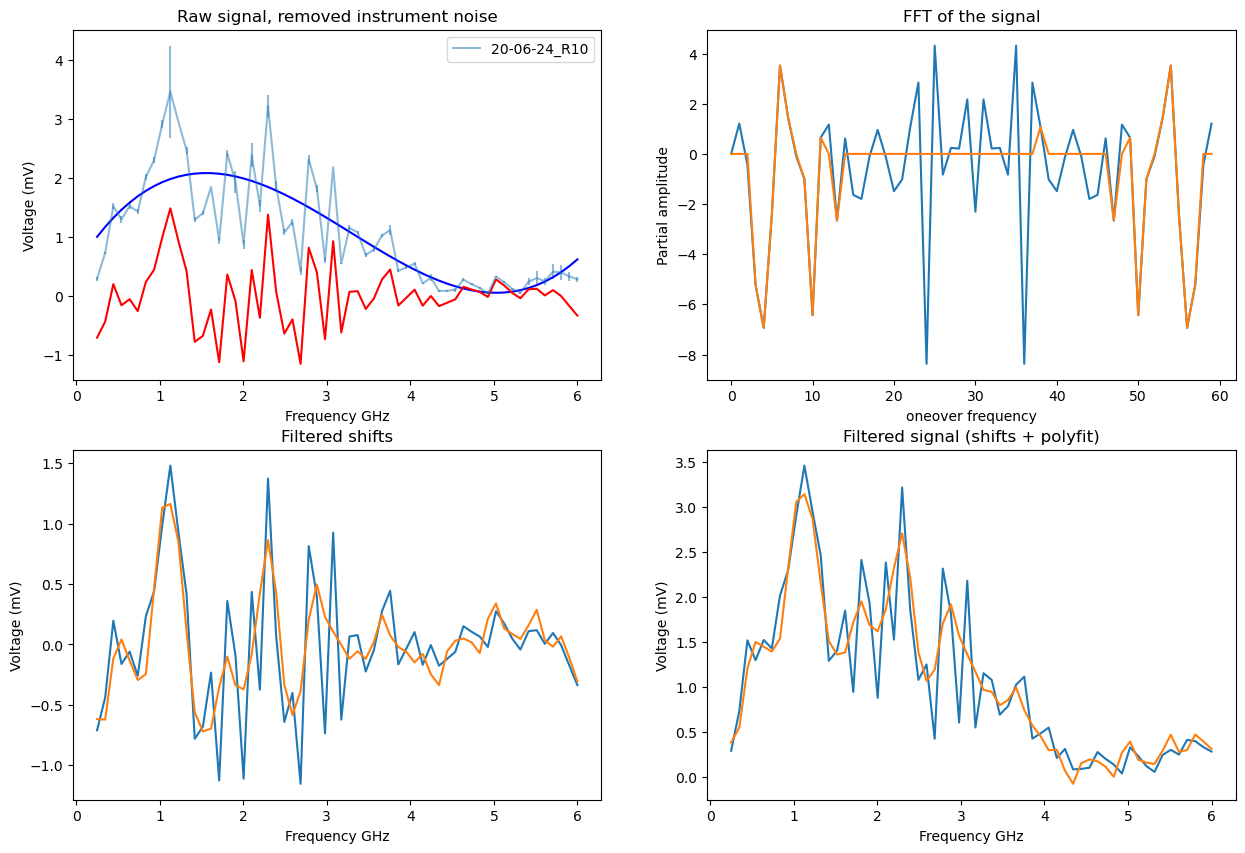

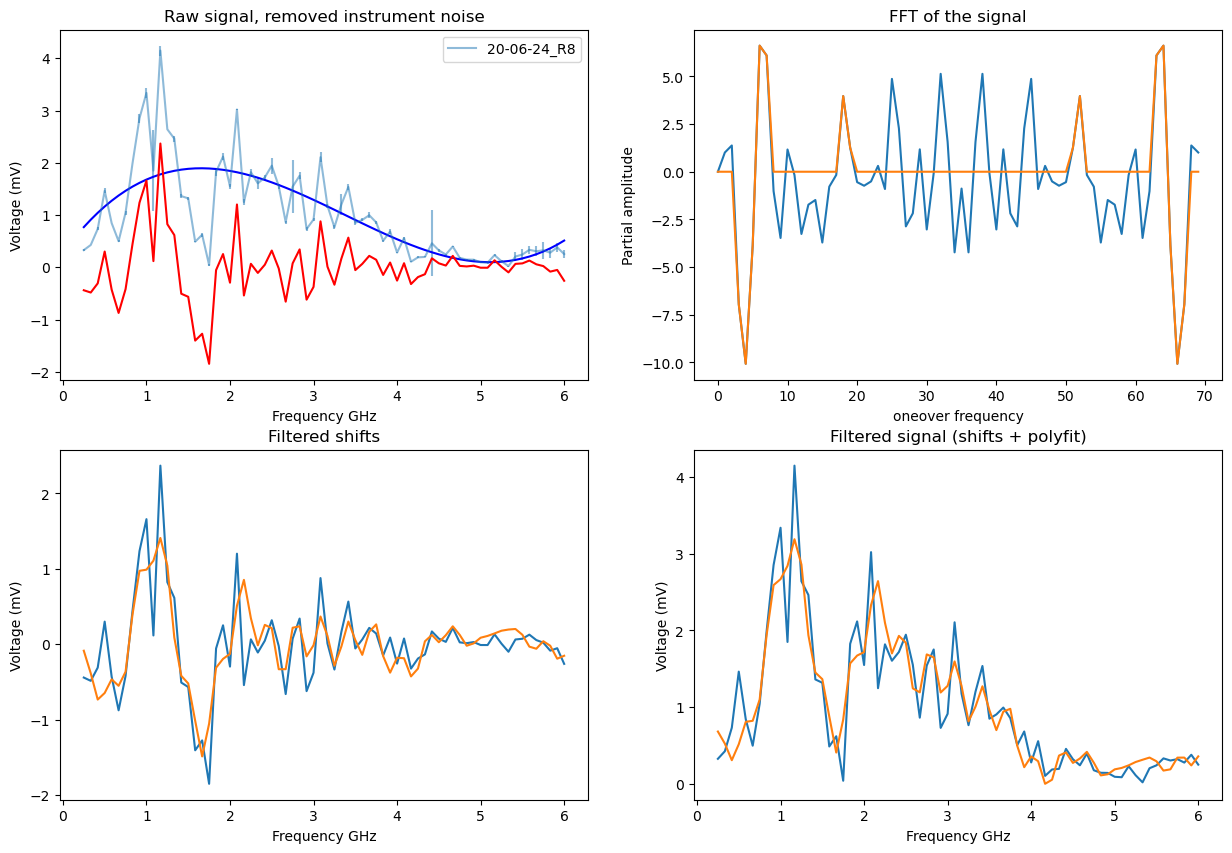

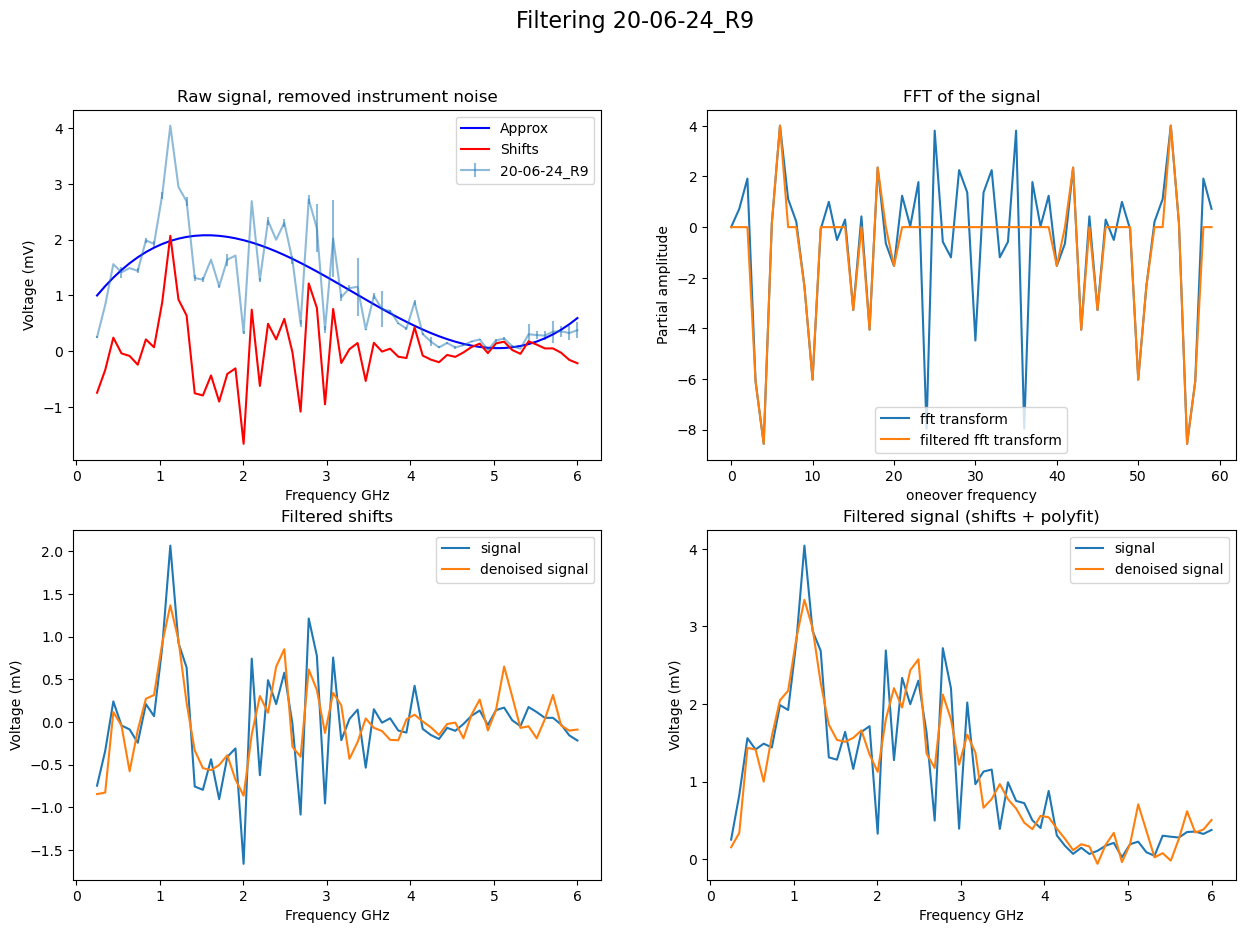

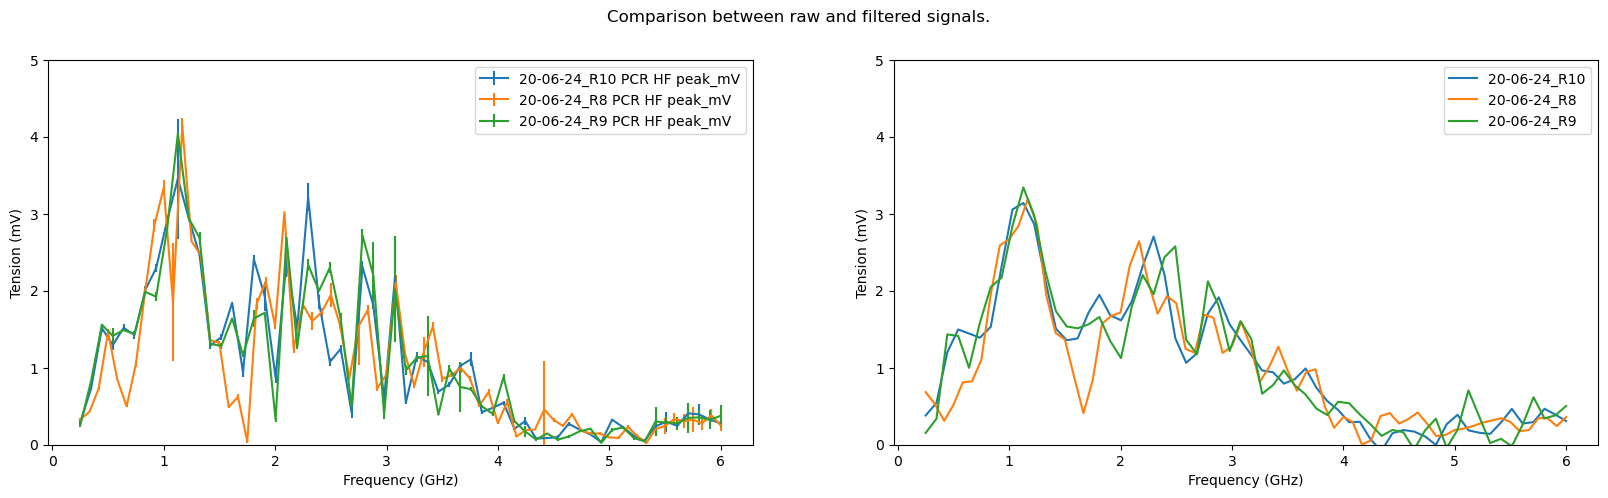

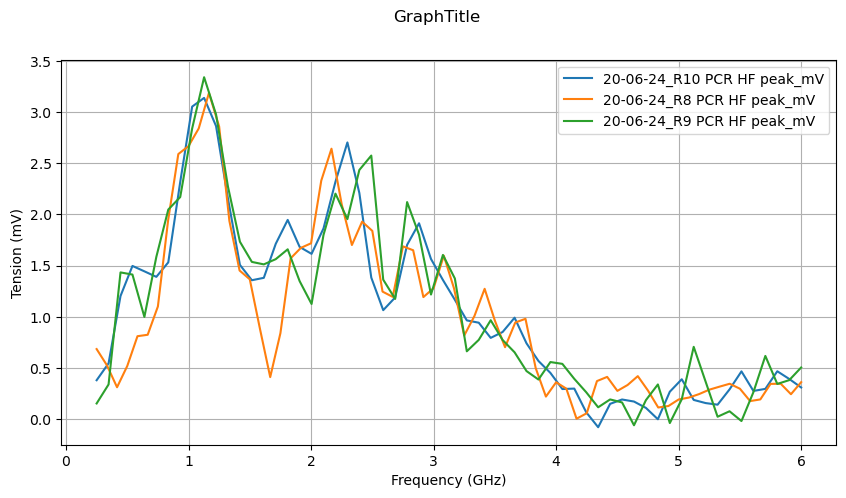

In [7]:
data = df[df['id'].isin(['20-06-24_R8', '20-06-24_R9','20-06-24_R10'])]
data = denoisePipe(data)
fft_denoise = FFTFilterPipe(data, 0.4, 8, plotFFT=True)
plotByID(fft_denoise)

Il problema adesso è sempre quello, combinare questi segnali...
Ho provato a dare un occhiata a come funzionano i filtri, ma non sembra quello di cui ho bisogno. Il modo più semplice per andare avanti e trovare un modo per ricostruire il segnale a partire da quelli che ho già vedendo la loro correlazione. Vediamo quindi se i segnali sono correlati o meno.

[[1.         0.85180345 0.94721643]
 [0.85180345 1.         0.84888181]
 [0.94721643 0.84888181 1.        ]]


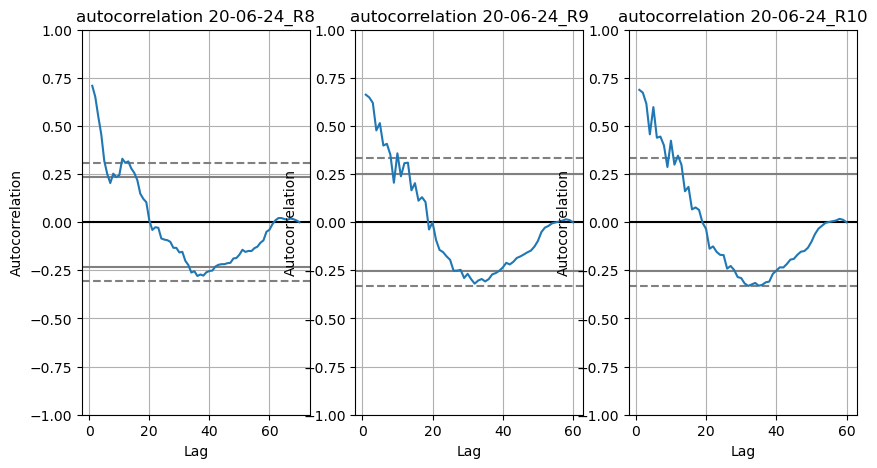

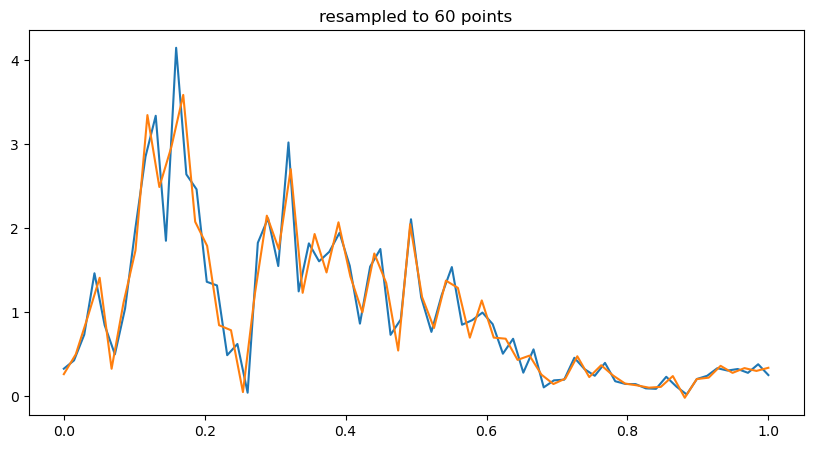

In [8]:
import scipy.signal
import scipy.stats

def CorrelationAnalysis():
    ids = ['20-06-24_R8', '20-06-24_R9','20-06-24_R10']
    data = df[df['id'].isin(ids)]
    
    # denoise data
    data = data.apply(denoise, axis=1)
    fig, axes = plt.subplots(1,3)
    
    for id, ax in zip(ids, axes.flatten()):  
        pd.plotting.autocorrelation_plot(data[data['id'] == id][k.pek], ax=ax)
        ax.set_title('autocorrelation %s'%id)
        ax.set_ylim(-1,1)


    # get the correlation between different columns
    series = {}
    for name, group in data.groupby('id'):
        series[name] = group[k.pek].values
    
    # resample the series with 70 elements to 60
    plt.subplots()
    plt.plot(np.linspace(0,1,70) , series[ids[0]])
    series[ids[0]] = scipy.signal.resample(series[ids[0]], 60, )
    plt.plot(np.linspace(0,1,60) , series[ids[0]])
    plt.title('resampled to 60 points')
    
    # print(series)
    print(np.corrcoef([i for i in series.values()]))

    return

CorrelationAnalysis()

Adesso che abbiamo delle idee più chiare sulla correlazione dei dati sarebbe bello unire tutti i segnali in modo da averne uno solo che meglio li rappresenti.
Possiamo fare ciò in questo modo: dati $x_1[n], \, $x_2[n]$, \, $x_3[n]$ le serie in input possiamo generare la loro unione $y[n]$ nel seguente modo:

$$ y[i] = \sum_{k = 1,2,3} a_k x_k[i]$$

tale che $\sum_k a_k = 1$, in questo modo la funzione rimane normalizzata. Ho solo due parametri liberi $a_1$ e $a_2$ e voglio massimizzare la somma delle correlazioni:

$$E = \sum_{ij} C_{ij}$$

nomal minimization weights:  [0.30294956 0.30320532 0.29383866]
correlation with the data:  [0.97257243 0.93607688 0.97156485 1.        ]
fft filtering minimization weights:  [0.30439534 0.29946755 0.29611345]
correlation with the data:  [0.97641871 0.95620708 0.97744589 1.        ]
 correlation between the two models:
 [[1.         0.96315682]
 [0.96315682 1.        ]]
cross correlation fft with the data:  [0.9271004  0.9230473  0.92474438 1.        ]
cross correlation normal with the fftdata:  [0.93648943 0.92992598 0.93663027 1.        ]


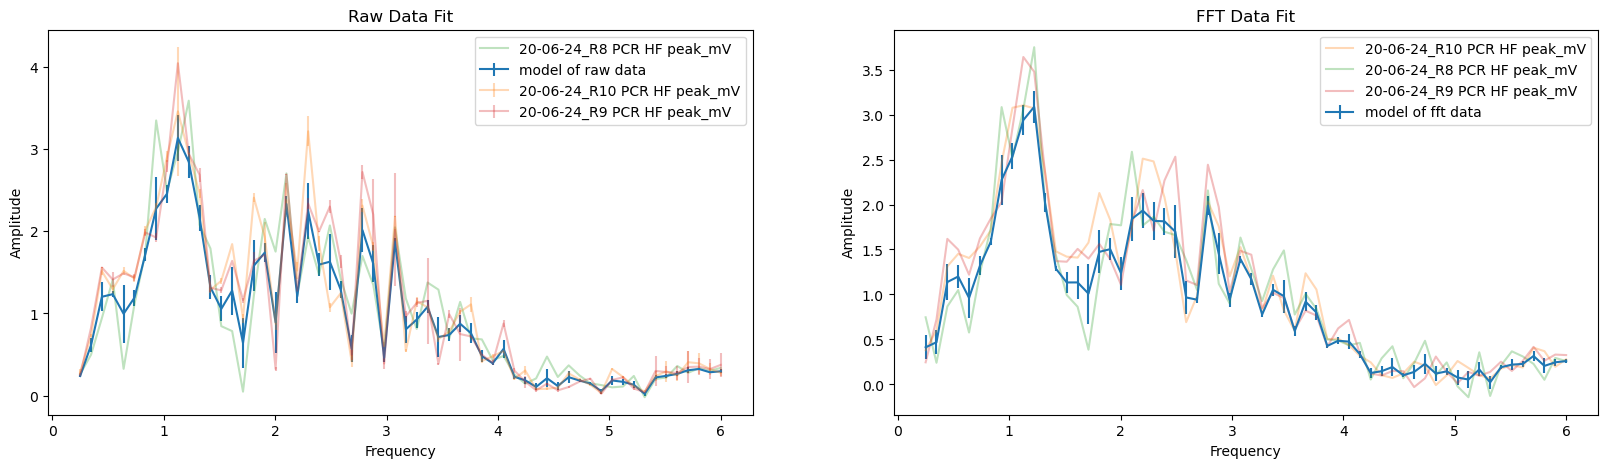

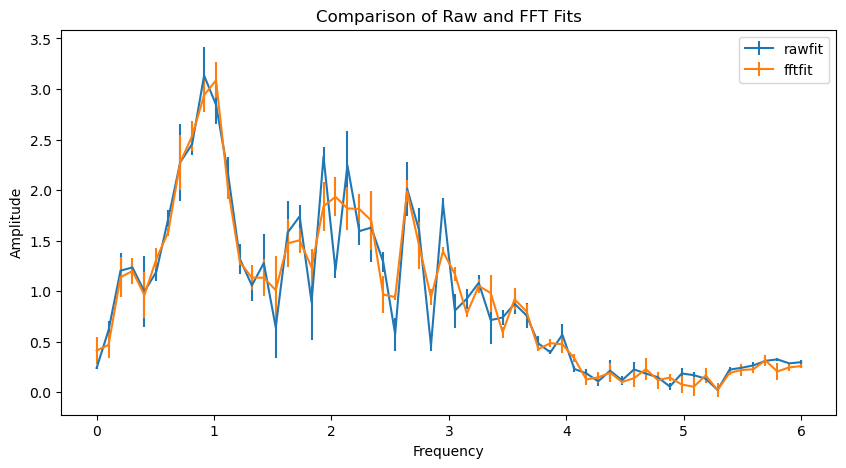

In [9]:
%load_ext autoreload
%autoreload 2

from utils import *

def TryToFitWithCorrelation():
    from scipy.optimize import minimize

    # RAW DATA
    #   get the data
    ids = ['20-06-24_R8', '20-06-24_R9','20-06-24_R10']
    rawdata = df[df['id'].isin(ids)]

    #   denoise data
    data = denoisePipe(rawdata)
    data = resamplePipe(data)

    #   minimize
    weights = [.3, .3, .3]
    def negcorr(weights, dataset):
        # here the dataset is fixed while the 
        # weights can change
        model = weightmean(dataset, weights)
        return -np.square(corrModelToData(dataset, model)).sum()
    
    res = minimize(negcorr, weights, data)
    print('nomal minimization weights: ', res['x'])
    print('correlation with the data: ', corrModelToData(data, weightmean(data, res['x'])))
    
    # FFT DENOISED DATA
    fft_data = denoisePipe(rawdata)
    fft_data = FFTFilterPipe(fft_data, 0.3, 8)
    fft_data = resamplePipe(fft_data)
    
    #   minimize
    weights = [.3, .3, .3]
    fftres = minimize(negcorr, weights, fft_data)
    print('fft filtering minimization weights: ', fftres['x'])
    print('correlation with the data: ', corrModelToData(fft_data, weightmean(fft_data, fftres['x'])))
    
    #   plot 
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs = axs.flatten()
    rawfit = weightmean(data, res['x'])
    axs[0].errorbar(data[data['id'] == ids[0]][k.freq], rawfit[0], yerr=rawfit[1], label='model of raw data')
    data.groupby('id').apply(plotThis, axs[0], alpha=0.3)
    axs[0].set_xlabel('Frequency')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Raw Data Fit')
    axs[0].legend()
    
    #   plot 
    fftfit = weightmean(fft_data, fftres['x'])
    axs[1].errorbar(fft_data[fft_data['id'] == ids[0]][k.freq], fftfit[0], yerr=fftfit[1], label='model of fft data')
    fft_data.groupby('id').apply(plotThis, axs[1], alpha=0.3)
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('FFT Data Fit')
    axs[1].legend()
   
    # togheter
    fig, ax = plt.subplots()
    x = np.linspace(0, 6, 60)
    plt.errorbar(x, rawfit[0], yerr=rawfit[1], label='rawfit')
    plt.errorbar(x, fftfit[0], yerr=fftfit[1], label='fftfit')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    ax.set_title('Comparison of Raw and FFT Fits')
    ax.legend()
    
    print(f' correlation between the two models:\n {np.corrcoef(rawfit[0], fftfit[0])}')
    print('cross correlation fft with the data: ', corrModelToData(data, weightmean(fft_data, fftres['x'])))
    print('cross correlation normal with the fftdata: ', corrModelToData(fft_data, weightmean(data, res['x'])))
       
    return

TryToFitWithCorrelation()

Importante: abbiamo scelto di prendere misure a diverse frequenze, prendendo 60, poi 70 punti. L'idea era di avere più punti per rendere lo spettro più liscio ma si è rivelato uno sbaglio, perché la cosa più importante era fare statistica in quanto i nostri dati cambiano da misura a misura. Per poter confrontare tra loro i diversi campioni ho dovuto fare un *resampling* del campione a 70 punti a 60. La prossima volta sarebbe meglio ripetere la stessa misura tante volte per poter fare statistica in modo più opportuno.

In ogni caso dall'ultimo grafico si vede che i due risultati provenienti direttamente dai dati e poi dalla trasformata di fourier sono abbastanza simili a meno di alcuni punti in cui sono incompatibili, ad esempio a 2.8GHz.

Un'altra cosa importante è che si vede che il filtro fatto sulla trasformata di Fourier funziona: il modello generato dalla trasformata di fourier è più in accordo con il campione senza filtri che il viceversa. Questo potrebbe indicare il fatto che applicando il filtro si mantiene una coerenza con i dati reali.